In [1]:
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
from math import *



In [2]:
class Maravilla:
    def __init__(self,name, x, y):
        self.name = name
        self.x = x
        self.y = y
    

    def distance(self, maravilla):
        """ Calculate the great circle distance between two points on the earth (specified in decimal degrees) """ 
       
        # haversine formula 
        
        xDis = abs(self.x - maravilla.x)
        yDis = abs(self.y - maravilla.y)
        
        a = sin(yDis/2)**2 + cos(self.y) * cos(maravilla.y) * sin(xDis/2)**2
        
        c = 2 * asin(sqrt(a)) 
        r = 3956 # 6371 Radius of earth in kilometers. Use 3956 for miles 
        distance = c*r
        
        return distance
    
    def __repr__(self):
        return "(" + str(self.name)+ ")"


In [3]:

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromMaravilla = self.route[i]
                toMaravilla = None
                if i + 1 < len(self.route):
                    toMaravilla = self.route[i + 1]
                else:
                    toMaravilla = self.route[0]
                pathDistance += fromMaravilla.distance(toMaravilla)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

MUTACION Y REPRODUCCION

In [4]:
#Se crea la poblacion inicial
#Generador de ruta
#Este método ordena aleatoriamente los destinos
def createRoute(listaMaravillas):
    route = random.sample(listaMaravillas, len(listaMaravillas))
    return route

In [5]:
#Se crea la primera población (lista de rutas)
#Este método crea una población aleatoria de un tamaño especifico


def initialPopulation(popSize, listaMaravillas):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(listaMaravillas))
    return population


In [6]:
#S e crea el algoritmo genetico
#Rank individuals
#Esta funcion toma una poblacion y la ordena en orden descendente usando la aptitud (fitness) de cada individuo (ruta)

def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    sorted_results=sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)
    return sorted_results

In [7]:
#Se crea una función de Selección que será utilizada para hacer la lista de rutas "Padres"
#cumsum = Return the cumulative sum of the elements along a given axis.


def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [8]:
#Se crea el Apareamiento

def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [9]:
# Se crea una función de Re-combinación (Cross over - reproducción) para 2 padres para crear un hijo

def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        

    childP2 = [item for item in parent2 if item not in childP1]
    print(startGene, endGene)

    print(parent1)
    print(parent2)

    print(childP1)
    print(childP2)
    child = childP1 + childP2

    print(child)
    return child

In [10]:
#Se crea una funcion para ejecutar la re-combinación sobre toda la piscina de apareamiento

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [11]:
#Se crea una función para mutar una sola ruta (individuo)
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [12]:
#Se crea una funcion para mutar la población completa
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [13]:
#Se ponen todos los pasos juntos para crear la siguiente generación
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

ALGORITMO GENETICO

In [14]:
#Se crea el algoritmo genetico

def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = [1 / rankRoutes(pop)[0][1]]
    print("Initial distance: " + str(progress[0]))
    
    for i in range(1, generations+1):
        
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
        if i%50==0:
            print('Generation '+str(i),"Distance: ",progress[i])
        
        
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.title('Best Fitness vs Generation')
    plt.tight_layout()
    plt.show()

    
    
    return bestRoute

PROBANDO EL ALGORITMO

In [15]:
#Crear la lista de individuos
listaMaravillas=[]

listaMaravillas.append(Maravilla(name = 0, x = -72.545128 , y = -13.163068 ))
listaMaravillas.append(Maravilla(name = 1, x = -89.578262 , y = 20.962910  ))
listaMaravillas.append(Maravilla(name = 2, x = 12.494270 , y = 41.890560))
listaMaravillas.append(Maravilla(name = 3, x = -43.2065 , y = -22.9510))
listaMaravillas.append(Maravilla(name = 4, x = 116.570374 , y = 40.431908))
listaMaravillas.append(Maravilla(name = 5, x = 78.042068 , y = 27.173891))
listaMaravillas.append(Maravilla(name = 6, x = 35.444832 , y = 30.328960))

#La latitud corresponde a las coordenadas Y, mientras que la longitud corresponde a las coordenadas X.
#    0Machu Picchu.longitud =-72.545128 , latitud=-13.163068  
#    1Chichén Itzá.longitud =-89.578262  ,latitud=20.962910
#    2Coliseo Romano.longitud = 12.494270, latitud= 41.890560
#    3Cristo Redentor.longitud= -43.2065, latitud= -22.9510
#    4La Gran Muralla China.longitud= 116.570374, latitud= 40.431908
#    5El Taj Mahal.longitud=78.042068, latitud= 27.173891
#   6La Ciudad de Petra.longitud=35.444832, latitud=30.328960

#for i in range(0,5):
#    listaMaravillas.append(Maravilla(name = i, x=int(random.random() * 200), y=int(random.random() * 200)))




In [16]:
listaMaravillas

[(0), (1), (2), (3), (4), (5), (6)]

Initial distance: 34324.59658860576
4 4
[(1), (2), (3), (5), (6), (4), (0)]
[(4), (1), (3), (5), (2), (0), (6)]
[]
[(4), (1), (3), (5), (2), (0), (6)]
[(4), (1), (3), (5), (2), (0), (6)]
3 6
[(5), (2), (3), (6), (0), (1), (4)]
[(1), (2), (0), (6), (5), (3), (4)]
[(6), (0), (1)]
[(2), (5), (3), (4)]
[(6), (0), (1), (2), (5), (3), (4)]
3 6
[(2), (1), (3), (4), (5), (0), (6)]
[(5), (6), (4), (0), (2), (3), (1)]
[(4), (5), (0)]
[(6), (2), (3), (1)]
[(4), (5), (0), (6), (2), (3), (1)]
1 2
[(5), (4), (3), (2), (0), (6), (1)]
[(0), (2), (6), (4), (3), (5), (1)]
[(4)]
[(0), (2), (6), (3), (5), (1)]
[(4), (0), (2), (6), (3), (5), (1)]
1 3
[(1), (0), (6), (4), (2), (3), (5)]
[(5), (0), (3), (1), (6), (2), (4)]
[(0), (6)]
[(5), (3), (1), (2), (4)]
[(0), (6), (5), (3), (1), (2), (4)]
4 6
[(4), (1), (3), (5), (2), (0), (6)]
[(6), (0), (2), (5), (1), (4), (3)]
[(2), (0)]
[(6), (5), (1), (4), (3)]
[(2), (0), (6), (5), (1), (4), (3)]
4 4
[(4), (1), (6), (0), (5), (3), (2)]
[(5), (3), (0), (1), (6), (2

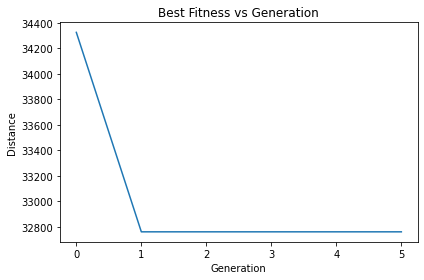

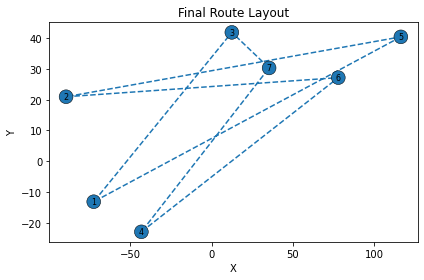

In [19]:

best_route=geneticAlgorithm(population=listaMaravillas, popSize=30, eliteSize=20, mutationRate=0.01, generations=5)
x=[]
y=[]

best_route

for i in best_route:
    x.append(i.x)
    y.append(i.y)
x.append(best_route[0].x)
y.append(best_route[0].y)
plt.plot(x, y, '--o')
plt.xlabel('X')
plt.ylabel('Y')
ax=plt.gca()
plt.title('Final Route Layout')
bbox_props = dict(boxstyle="circle,pad=0.3", fc='C0', ec="black", lw=0.5)
for i in range(1,len(listaMaravillas)+1):
    ax.text(listaMaravillas[i-1].x, listaMaravillas[i-1].y, str(i), ha="center", va="center",
            size=8,
            bbox=bbox_props)
plt.tight_layout()
plt.show()